# 21. Процессы восстановления

In [18]:
import sys
sys.path.append("/Users/PredatoryMink/Statistics")

import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import scipy.special as sp
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm
from mystats.utils import plot
from mystats.criterion import fit as myfit

### Задание 1

In [2]:
def plot_excess(step, N=1000, t=100):
    excess = np.zeros(N)
    for i in range(N):
        cur = 0
        while cur < t:
            cur += step.rvs()
        excess[i] = cur - t
    #sns.kdeplot(excess, label=fr'$t={t}$')
    sns.histplot(excess, stat="density", label=fr'$t={t}$')

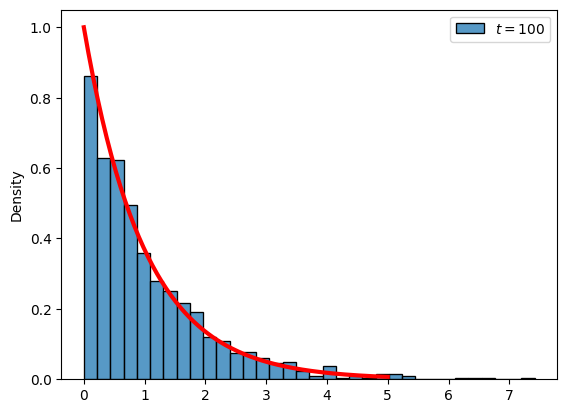

In [3]:
a = 1

plot_excess(st.expon(scale=1/a))

xs = np.linspace(0, 5/a, 200)
ys = st.expon(scale=1/a).pdf(xs)
plt.plot(xs, ys, c='r', lw=3)
plt.legend();

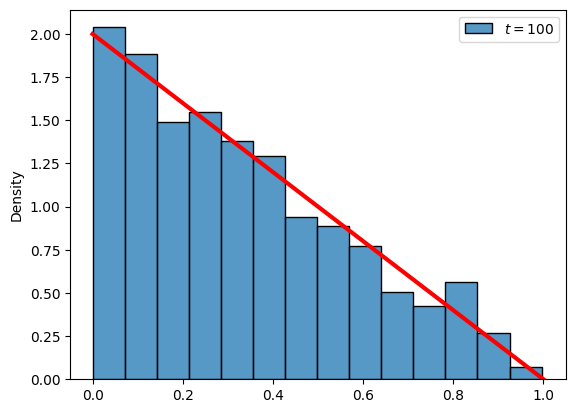

In [4]:
plot_excess(st.uniform())

xs = np.linspace(0, 1, 200)
ys = 2 * (1 - xs)
plt.plot(xs, ys, c='r', lw=3)
plt.legend();

### Задание 2

In [5]:
def Pablo(rv, T=100, N=10_000, K=1_000):
    excess = np.zeros(K)
    steps = rv.rvs((K, N))
    process = steps.cumsum(axis=1)
    for i in range(K):
        ind = np.searchsorted(process[i], T, side='right')
        excess[i] = process[i][ind] - T
    return excess

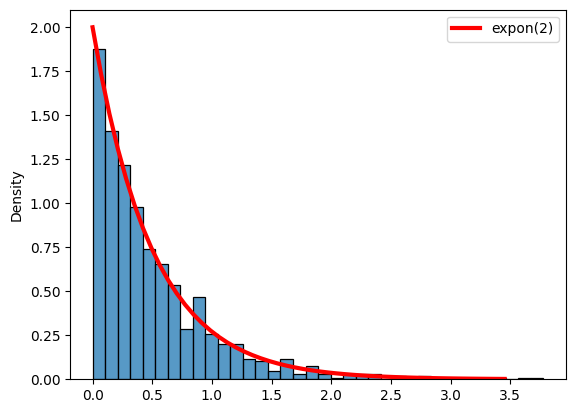

In [6]:
a = 2
rv = st.expon(scale=1/a)
excess = Pablo(rv)
sns.histplot(excess, stat='density');
xs = np.linspace(0, -mt.log(1e-3) / a)
ys = rv.pdf(xs)
plt.plot(xs, ys, lw=3, c='r', label=f"{rv.dist.name}({a})")
plt.legend();

In [7]:
a, b = 2, 1/4
rv = st.gamma(a, scale=b)
excess = Pablo(rv)
mean = excess.mean()
print(f"Mean estimation: {mean}")
print(f"Naive mean: {rv.mean() / 2}")

Mean estimation: 0.36898436663133205
Naive mean: 0.25


In [8]:
rv = st.uniform()
excess = Pablo(rv)
mean = excess.mean()
print(f"Mean estimation: {mean}")
print(f"Naive mean: {rv.mean() / 2}")

Mean estimation: 0.33897470489202547
Naive mean: 0.25


### Задание 3

In [9]:
a = 2
N = 10_000
seg = [0, 100]

points = st.expon(scale=1/a).rvs(N).cumsum()
ind_left = np.searchsorted(points, seg[0])
ind_right = np.searchsorted(points, seg[1], side='right')
points = points[ind_left : ind_right]

myfit.AD_fit_test(points, st.uniform(seg[0], seg[1] - seg[0]).cdf)

ADFitTestResult(statistic=0.5301673751832539, pvalue=0.71716)

$$P(R_{(1)} > r) = \exp(-\lambda \pi r^2)$$
$$P(R_{(2)} > r | R_{(1)}) = \exp(-\lambda \pi (r^2 - R_{(1)}^2))$$
$$\ldots$$
$$P(R_{(k + 1)} > r | R_{(1)} \ldots R_{(k)}) = \exp(-\lambda \pi (r^2 -R_{(k)}^2))$$

In [10]:
a = 1
N = 200

theta = st.uniform(0, 2 * mt.pi).rvs(N)
r = np.zeros(N)
uni = st.uniform(0, 1).rvs(N)
cur_r = 0
for i in range(N):
    r[i] = mt.sqrt(cur_r ** 2 - mt.log(uni[i]) / (a * mt.pi))
    cur_r = r[i]

x = r * np.cos(theta)
y = r * np.sin(theta)

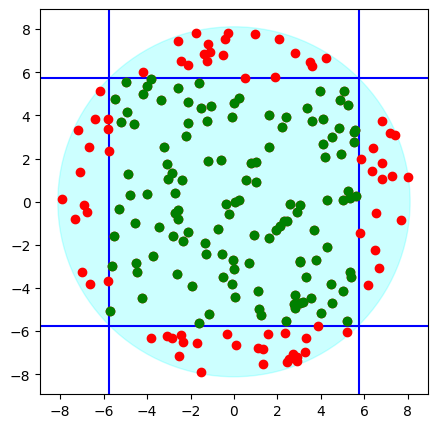

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.add_patch(plt.Circle((0, 0), r[-1], color='cyan', alpha=0.2))

side = r[-1] / 2**0.5
plt.axvline(-side, c='b');
plt.axvline(side, c='b');
plt.axhline(-side, c='b');
plt.axhline(side, c='b');

plt.plot(x, y, 'o', c='r');
good = (-side < x) & (x < side) & (-side < y) & (y < side)
x = x[good]
y = y[good]
plt.plot(x, y, 'o', c='g');

In [12]:
S = 5 #S^2 cells

split = np.linspace(-side, side, S + 1)
i = np.searchsorted(split, x) - 1
j = np.searchsorted(split, y) - 1
f_obs = np.bincount(i + S * j)

st.chisquare(f_obs)

Power_divergenceResult(statistic=20.8, pvalue=0.6504939222376933)

### Задание 4

In [13]:
def conf_int(k, ratio):
    alpha = 0.05
    q = st.norm().ppf(1 - alpha/2)
    left = 1/ratio * (k - k**0.5 * q)
    right = 1/ratio * (k + k**0.5 * q)
    print(f"Оценка: {1/ratio * k}")
    print(f"Интервал: ({left} ; {right})")

In [14]:
conf_int(30, 1/4)

Оценка: 120.0
Интервал: (77.05934055078822 ; 162.94065944921178)


In [15]:
conf_int(36, 1/4)

Оценка: 144.0
Интервал: (96.9608643710387 ; 191.0391356289613)


### Задание 5

In [27]:
Ns = [100, 300, 700, 1000, 1500, 2000, 2500, 3000, 5000]
res = {'Kruskal' : []}#, 'ANOVA' : []}
for n in Ns:
    x = [np.r_[np.ones(30, int), np.zeros(n, int)],
         np.r_[np.ones(33, int), np.zeros(n, int)],
         np.r_[np.ones(35, int), np.zeros(n, int)],
         np.r_[np.ones(36, int), np.zeros(n, int)]
    ]
    res['Kruskal'].append(st.kruskal(*x).pvalue)
    #res['ANOVA'].append(st.f_oneway(*x).pvalue)

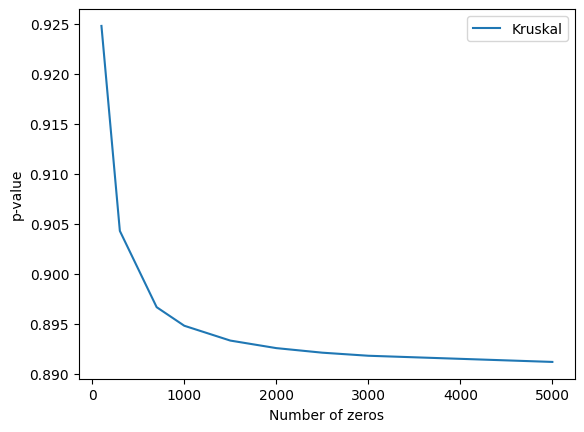

In [28]:
plt.xlabel("Number of zeros")
plt.ylabel("p-value")
for name, p_val in res.items():
    plt.plot(Ns, p_val, label=name)
plt.legend();